In [1]:
import json
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx


# load files:
data = []
filenames = ["hamlet","city","town","village"]

for filename in filenames:
    with open(f"de/place-{filename}.ndjson", "r") as file:
        data_to_add = [json.loads(line) for line in file]
        data += data_to_add

print(data[0])

{'name': 'Außer Ay', 'display_name': 'Außer Ay, Weilheim, Verwaltungsgemeinschaft Waldshut-Tiengen, Landkreis Waldshut, Baden-Württemberg, Deutschland', 'address': {'hamlet': 'Außer Ay', 'village': 'Weilheim', 'municipality': 'Verwaltungsgemeinschaft Waldshut-Tiengen', 'county': 'Landkreis Waldshut', 'state': 'Baden-Württemberg', 'ISO3166-2-lvl4': 'DE-BW', 'country': 'Deutschland', 'country_code': 'de'}, 'osm_type': 'way', 'osm_id': 169823214, 'type': 'hamlet', 'location': [8.1840732737376, 47.67113545], 'bbox': [8.1827035, 47.6706276, 8.1855379, 47.6715884]}


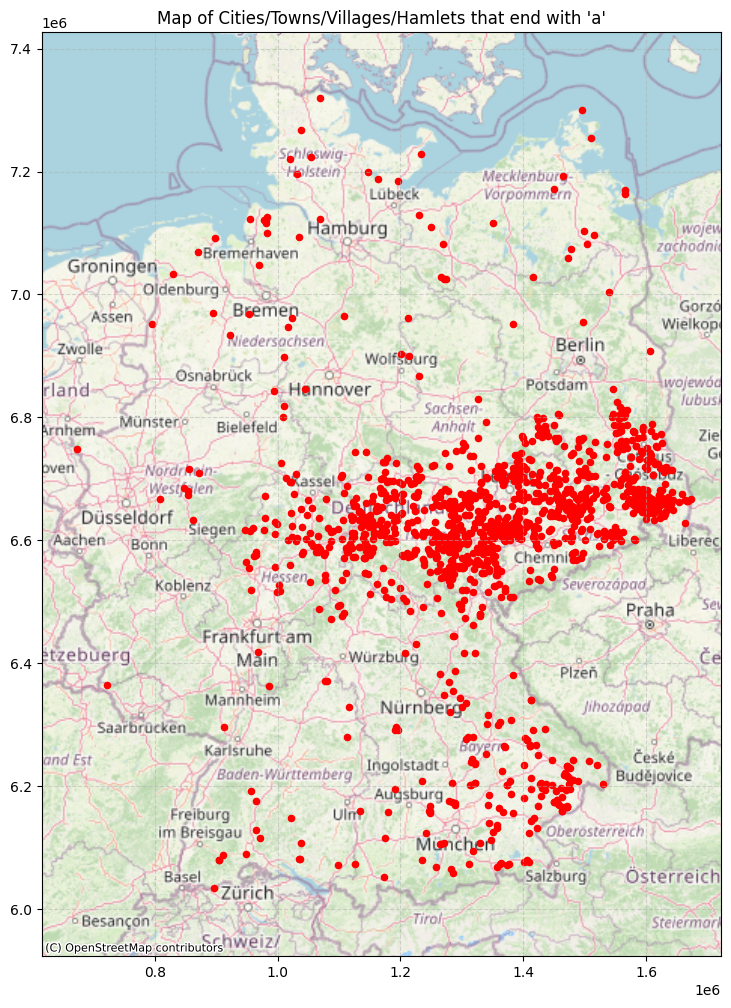

In [2]:
# load map data
world = gpd.read_file("ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")
germany = world[world["NAME"] == "Germany"]

# convert Germany GeoDataFrame to Web Mercator (EPSG:3857) for compatibility with basemaps
germany = germany.to_crs(epsg=3857)


# filter entries with "name" and apply additional conditions
filtered_data = []
for entry in data:
    entry_name = " "
    if "name" in entry.keys():
        entry_name = entry["name"]
    # if no name try display_name:
    elif "display_name" in entry.keys():   
        entry_name = entry["display_name"]

        # filter out additional information:
        if entry_name.find(",") != -1:
            entry_name = entry_name[:entry_name.find(",")]
            
    # remove name specifiers e.g. Waren (Müritz) => Waren
    if entry_name.find("(") != -1:
        entry_name = entry_name[:entry_name.find("(")]

    # select if ends in 'a
    if len(entry_name) > 0:
        if entry_name[-1] == "a":
            filtered_data.append(entry)

# extract longitudes and latitudes
longitudes = [entry["location"][0] for entry in filtered_data]
latitudes = [entry["location"][1] for entry in filtered_data]

# convert points to GeoDataFrame, convert to Web Mercator for basemap overlay
points_gdf = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(longitudes, latitudes),
    crs="EPSG:4326" 
).to_crs(epsg=3857)  


fig, ax = plt.subplots(figsize=(12, 12))

# plot the map of Germany
germany.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=0)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=6)

# plot towns:
points_gdf.plot(ax=ax, color="red", markersize=20, label="Filtered Cities/Towns")  # Increased marker size

plt.title("Map of Cities/Towns/Villages/Hamlets that end with 'a'")
plt.grid(True, linestyle="--", alpha=0.5)
plt.savefig("map_with_towns_ending_with_a.png")

plt.show()
